# scVAE notebook example

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sklearn as sk
import seaborn as sns
import tensorflow as tf
# import tensorflow_probability as tfp
import umap

import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from scVAE import *

## Read data

In [2]:
# Read in and get the data in the correct formatting
raw_data = pd.read_csv("./Example Data/synthetic_2K_features.csv")
raw_data = raw_data.transpose()
raw_data.columns = raw_data.iloc[0]
raw_data = raw_data.iloc[1:] #drop the first row since it is just the same as the columns names, no extra info
# raw_data.shape is 10000 x 2000
raw_data.head()

Unnamed: 0,Gene3544,Gene1188,Gene4257,Gene4446,Gene9899,Gene8825,Gene5997,Gene9718,Gene5753,Gene4556,...,Gene7915,Gene1073,Gene4457,Gene8266,Gene8914,Gene7088,Gene2412,Gene8599,Gene5192,Gene109
Cell1_1,4,0,0,0,259,0,84,4,10,0,...,0,29,6,0,0,5,0,4,12,19
Cell2_1,60,0,0,0,37,0,10,4,20,0,...,3,32,10,4,0,0,0,0,2,41
Cell3_1,19,0,0,0,134,0,21,12,7,0,...,5,20,1,9,0,0,0,7,9,7
Cell4_1,5,0,0,0,164,0,47,0,46,0,...,0,38,3,1,1,0,0,0,5,3
Cell5_1,2,0,0,0,45,0,72,1,4,0,...,2,20,6,3,4,5,0,9,12,20


In [3]:
# Read in the clusters (label information)
clusters = pd.read_csv("./Example Data/synthetic_clusters_processed.csv")
clusters.head()

,Cell,Original Cluster,Cluster Nr
0,Cell1_1,Group5,5
1,Cell2_1,Group4,4
2,Cell3_1,Group5,5
3,Cell4_1,Group2,2
4,Cell5_1,Group1,1


## Preprocess data

In [4]:
# Log transform the data
log_data = raw_data.astype(np.float32).apply(lambda x: np.log2(x+1), axis=1)
log_data.head()

Unnamed: 0,Gene3544,Gene1188,Gene4257,Gene4446,Gene9899,Gene8825,Gene5997,Gene9718,Gene5753,Gene4556,...,Gene7915,Gene1073,Gene4457,Gene8266,Gene8914,Gene7088,Gene2412,Gene8599,Gene5192,Gene109
Cell1_1,2.321928,0.0,0.0,0.0,8.022367,0.0,6.409391,2.321928,3.459432,0.0,...,0.000000,4.906890,2.807355,0.000000,0.000000,2.584962,0.0,2.321928,3.700440,4.321928
Cell2_1,5.930737,0.0,0.0,0.0,5.247928,0.0,3.459432,2.321928,4.392317,0.0,...,2.000000,5.044394,3.459432,2.321928,0.000000,0.000000,0.0,0.000000,1.584962,5.392317
Cell3_1,4.321928,0.0,0.0,0.0,7.076816,0.0,4.459432,3.700440,3.000000,0.0,...,2.584962,4.392317,1.000000,3.321928,0.000000,0.000000,0.0,3.000000,3.321928,3.000000
Cell4_1,2.584962,0.0,0.0,0.0,7.366322,0.0,5.584962,0.000000,5.554589,0.0,...,0.000000,5.285402,2.000000,1.000000,1.000000,0.000000,0.0,0.000000,2.584962,2.000000
Cell5_1,1.584962,0.0,0.0,0.0,5.523562,0.0,6.189825,1.000000,2.321928,0.0,...,1.584962,4.392317,2.807355,2.000000,2.321928,2.584962,0.0,3.321928,3.700440,4.392317


In [5]:
# Standardize data
standardizer = StandardScaler()
standard_data = standardizer.fit_transform(log_data)
standard_df = pd.DataFrame(standard_data)
standard_df.columns = raw_data.columns
scaled_df=standard_df
del standard_df
scaled_df.head()

Unnamed: 0,Gene3544,Gene1188,Gene4257,Gene4446,Gene9899,Gene8825,Gene5997,Gene9718,Gene5753,Gene4556,...,Gene7915,Gene1073,Gene4457,Gene8266,Gene8914,Gene7088,Gene2412,Gene8599,Gene5192,Gene109
0,-1.788066,-0.03666,-0.046821,-0.02976,1.611057,-0.043207,1.099255,0.527985,-0.389873,-0.026841,...,-0.500725,0.204284,-0.555330,-1.929204,-0.738189,1.548683,-0.32207,1.148038,0.405082,-0.447050
1,0.376743,-0.03666,-0.046821,-0.02976,-0.098011,-0.043207,-0.672756,0.527985,0.177157,-0.026841,...,2.218380,0.291503,-0.143403,-0.458667,-0.738189,-0.816446,-0.32207,-0.854644,-0.917032,0.243091
2,-0.588331,-0.03666,-0.046821,-0.02976,1.028592,-0.043207,-0.072066,1.475627,-0.669127,-0.026841,...,3.013667,-0.122108,-1.697065,0.174659,-0.738189,-0.816446,-0.32207,1.732881,0.168523,-1.299372
3,-1.630281,-0.03666,-0.046821,-0.02976,1.206930,-0.043207,0.604029,-1.068198,0.883614,-0.026841,...,-0.500725,0.444374,-1.065349,-1.295878,0.236696,-0.816446,-0.32207,-0.854644,-0.292060,-1.944129
4,-2.230149,-0.03666,-0.046821,-0.02976,0.071781,-0.043207,0.967364,-0.380759,-1.081276,-0.026841,...,1.654115,-0.122108,-0.555330,-0.662552,1.525425,1.548683,-0.32207,2.010547,0.405082,-0.401666


## Define and train model

In [6]:
encoder_hidden_structure = [1500, 1000, 1000, 500, 500, 250, 250, 32, 16, 8, 2]
name = "PReLU-BothNonLinear-Weight2"

decoder_hidden_structure = encoder_hidden_structure[::-1][1:] # Inverse of encoder
epochs = 1000
batch_size = 252
max_value_kl_weight = 2
warmup_epochs = 500
function = "linear"

# Set (adaptive) lr
lr = 0.0001
adaptive_lr = LearningRateScheduler(step_lr, verbose=1)

vae = VAE()
vae.set_encoder(n_input=scaled_df.shape[1], hidden_structure=encoder_hidden_structure)
vae.set_decoder(n_output=scaled_df.shape[1], hidden_structure=decoder_hidden_structure, n_latent=encoder_hidden_structure[-1])

# vae.set_linear_encoder(n_input=scaled_df.shape[1], hidden_structure=encoder_hidden_structure)
# vae.set_linear_decoder(n_output=scaled_df.shape[1], hidden_structure=decoder_hidden_structure, n_latent=encoder_hidden_structure[-1])

vae.compile(optimizer=Adam(learning_rate=lr))

initial_time = datetime.datetime.now()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=400)
warmingup = WarmingupKL(vae, warmup_epochs, max_value_kl_weight, function)
accuracy = accuracy_per_epoch(model=vae, data=scaled_df, clusters=clusters, name=name)

history = vae.fit(scaled_df.to_numpy().astype(np.float32), scaled_df.to_numpy().astype(np.float32), epochs=epochs,
                  batch_size=batch_size,callbacks=[warmingup, accuracy]) #adaptive_lr, callback])

print("It took {} min to train the model.".format(datetime.datetime.now()-initial_time))

Epoch 1/7
40/40 [==============================] - 27s 687ms/step - loss: 2001.2821 - reconstruction_loss: 2001.2821 - kl_loss: 0.0000e+00 - KL Weight: 0.0000e+00
Epoch 2/7
40/40 [==============================] - 26s 653ms/step - loss: 1999.4989 - reconstruction_loss: 1999.4984 - kl_loss: 5.4721e-04 - KL Weight: 0.0040
Epoch 3/7
40/40 [==============================] - 27s 671ms/step - loss: 1999.7450 - reconstruction_loss: 1999.7434 - kl_loss: 0.0016 - KL Weight: 0.0080
Epoch 4/7
40/40 [==============================] - 26s 649ms/step - loss: 1999.6142 - reconstruction_loss: 1999.5787 - kl_loss: 0.0355 - KL Weight: 0.0120
Epoch 5/7
40/40 [==============================] - 23s 587ms/step - loss: 1997.0794 - reconstruction_loss: 1996.8444 - kl_loss: 0.2351 - KL Weight: 0.0160
Epoch 6/7
40/40 [==============================] - 27s 681ms/step - loss: 1993.1415 - reconstruction_loss: 1992.5637 - kl_loss: 0.5778 - KL Weight: 0.0200
Epoch 7/7
40/40 [==============================] - 25s 628

## Show accuracy plots and metrics

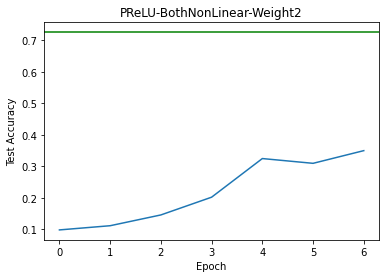

In [7]:
accuracy.show_accuracy_plot()

In [8]:
print(accuracy.metrics_report())

{'1': {'precision': 0.17834394904458598, 'recall': 0.1691842900302115, 'f1-score': 0.17364341085271318, 'support': 331}, '2': {'precision': 0.12618296529968454, 'recall': 0.12422360248447205, 'f1-score': 0.1251956181533646, 'support': 322}, '3': {'precision': 0.16607773851590105, 'recall': 0.1441717791411043, 'f1-score': 0.15435139573070605, 'support': 326}, '4': {'precision': 0.9970845481049563, 'recall': 0.9941860465116279, 'f1-score': 0.9956331877729258, 'support': 344}, '5': {'precision': 0.2836734693877551, 'recall': 0.4064327485380117, 'f1-score': 0.33413461538461536, 'support': 342}, '6': {'precision': 0.31216931216931215, 'recall': 0.38311688311688313, 'f1-score': 0.34402332361516036, 'support': 308}, '7': {'precision': 0.22093023255813954, 'recall': 0.1792452830188679, 'f1-score': 0.19791666666666666, 'support': 318}, '8': {'precision': 0.5861111111111111, 'recall': 0.6413373860182371, 'f1-score': 0.6124818577648766, 'support': 329}, '9': {'precision': 0.296028880866426, 'reca

## Losses

### Total loss

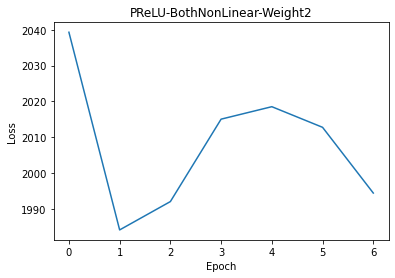

In [9]:
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(name)
plt.show()

### Reconstruction loss

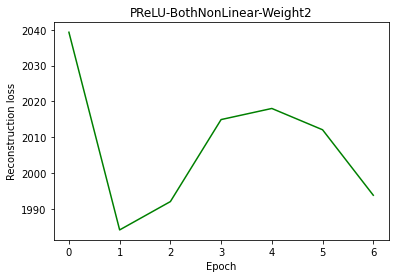

In [10]:
plt.plot(history.history["reconstruction_loss"], 'g')
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")
plt.title(name)
plt.show()

### KL Loss

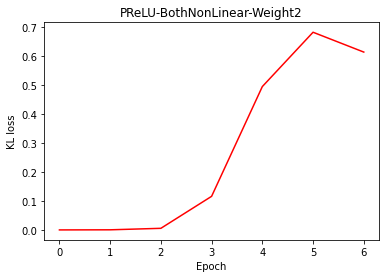

In [11]:
kl_loss_plot = plt.plot(history.history["kl_loss"], "r")
plt.xlabel("Epoch")
plt.ylabel("KL loss")
plt.title(name)
plt.show()

## Get and visualize latent space

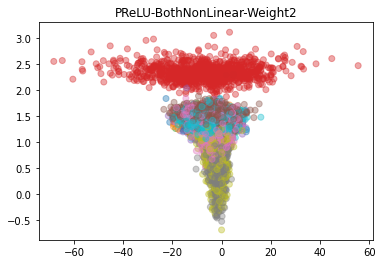

In [12]:
_, _, latent = vae.get_encoder().predict(scaled_df.to_numpy().astype(np.float32))
plt.scatter(latent[:,0],latent[:,1], alpha=.4, c=clusters["Cluster Nr"], cmap="tab10")
plt.title(name)
plt.show()

## Get reconstructions

In [13]:
reconstructed = vae.predict(scaled_df.to_numpy().astype(np.float32)).numpy()
reconstructed = pd.DataFrame(reconstructed, columns=raw_data.columns, index=raw_data.index)
# reconstructed.to_csv("./reconstructed_normalized.csv")
reconstructed.head()

Unnamed: 0,Gene3544,Gene1188,Gene4257,Gene4446,Gene9899,Gene8825,Gene5997,Gene9718,Gene5753,Gene4556,...,Gene7915,Gene1073,Gene4457,Gene8266,Gene8914,Gene7088,Gene2412,Gene8599,Gene5192,Gene109
Cell1_1,-0.000584,-0.000156,-0.000445,-0.000054,0.100541,0.000005,-0.001322,0.005466,-0.000509,-0.000221,...,0.000022,-0.001259,-3.058251e-06,0.005053,0.000264,0.026059,-0.000013,-0.000154,-0.000123,0.001643
Cell2_1,-0.038439,-0.000785,-0.002054,-0.000236,-0.000287,0.000012,-0.039676,0.006558,-0.004887,-0.000019,...,0.000150,-0.009865,-1.672314e-04,0.004307,0.021900,-0.001991,-0.000037,-0.000937,0.126742,0.019592
Cell3_1,-0.003624,-0.000152,-0.000563,-0.000022,0.083404,0.000004,-0.004116,0.002483,-0.000464,-0.000213,...,0.000021,-0.001833,-8.826333e-07,0.001684,0.001127,0.038112,-0.000007,-0.000130,0.000759,0.002104
Cell4_1,-0.005091,-0.000175,-0.000689,-0.000024,0.087753,0.000004,-0.005662,0.002269,-0.000545,-0.000228,...,0.000025,-0.002272,-7.531799e-07,0.001494,0.001629,0.042760,-0.000008,-0.000134,0.012360,0.002706
Cell5_1,-0.004348,-0.000168,-0.000644,-0.000026,0.093145,0.000005,-0.004865,0.002639,-0.000515,-0.000234,...,0.000023,-0.002111,-4.284352e-07,0.001784,0.001322,0.041528,-0.000008,-0.000141,0.003637,0.002427
